# Voice Activity

In [1]:
import os
import librosa
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Activation, Conv1D, MaxPooling1D, Dense
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import itertools

import matplotlib.pyplot as plt

import librosa
from librosa import display
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)


In [4]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

### Relative Path

In [5]:
cur_path = os.getcwd()

# 1. Read Sample File

In [6]:
recordNames = os.listdir("./ses/")
SampleNumbers = {}
recordNames.remove('.DS_Store')
recordNames.sort()

In [7]:
recordDatasets = {}
numberOfSamples = []
for recordName in recordNames:
    path_0 = os.path.relpath(f'./ses/{recordName}/samples_0', cur_path)
    path_1 = os.path.relpath(f'./ses/{recordName}/samples_1', cur_path)
    AudioFiles_0 = [f for f in os.listdir(path_0) if os.path.isfile(os.path.join(path_0, f))]
    AudioFiles_1 = [f for f in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, f))]
    SampleNumbers[recordName] = {
        "Child" : len(AudioFiles_1),
        "NonChild" : len(AudioFiles_0)
    }
    features = []
    labels = []
    n = min(len(AudioFiles_0), len(AudioFiles_1))
    selectedSamples_0 = random.sample(AudioFiles_0, n)
    selectedSamples_1 = random.sample(AudioFiles_1, n)
    for i in range(n):
        features.append(extract_feature(path_0 + "/" + selectedSamples_0[i], mfcc=True, chroma=True, mel=True))
        labels.append(0)
        features.append(extract_feature(path_1 + "/" + selectedSamples_1[i], mfcc=True, chroma=True, mel=True))
        labels.append(1)
    print(f"Dataset: {recordName} Number of Samples: {len(labels)}")
    recordDatasets[f"{recordName}"] = {
        "features" : features,
        "labels" : labels
    }
    numberOfSamples.append(len(labels))


Dataset: 4CH067I Number of Samples: 462
Dataset: 4CH068I Number of Samples: 1848
Dataset: 4CH069I Number of Samples: 636
Dataset: 4CH071I Number of Samples: 152
Dataset: 4CH072I Number of Samples: 398
Dataset: ENG1 Number of Samples: 900
Dataset: ENG2 Number of Samples: 652
Dataset: ENG3 Number of Samples: 664
Dataset: MAAP2 Number of Samples: 988
Dataset: MAAP3 Number of Samples: 1096
Dataset: MAAP7 Number of Samples: 1320
Dataset: POL1 Number of Samples: 282
Dataset: POL2 Number of Samples: 224


In [8]:
X, y = [], []
for recordName in recordNames:
    X.extend(recordDatasets[recordName]['features'])
    y.extend(recordDatasets[recordName]['labels'])
X = np.array(X)
y = np.array(y)

In [9]:
X.shape

(9622, 180)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
def returnModel():
    model=Sequential()
    ###first layer
    model.add(Dense(100,input_shape=(180,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    ###third layer
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    ###final layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

## 5 FOLD CV

In [12]:
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    model=returnModel()
    model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')
    num_epochs = 150
    num_batch_size = 32
    
    model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=0)

    test_accuracy=model.evaluate(X_test,y_test,verbose=0)
    print(test_accuracy[1]) 
    


2022-06-19 23:33:40.952234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.7646753191947937
0.7672727108001709
0.7442827224731445
0.7167359590530396
0.7214137315750122


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    model=LogisticRegression()
    num_epochs = 150
    num_batch_size = 32
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    
    # Importing all necessary libraries
    from sklearn.metrics import accuracy_score
    # Calculating the accuracy of classifier
    print(f"Accuracy of the classifier is: {accuracy_score(y_test, pred)}")
    


Accuracy of the classifier is: 0.745974025974026
Accuracy of the classifier is: 0.7262337662337662
Accuracy of the classifier is: 0.604989604989605
Accuracy of the classifier is: 0.6174636174636174
Accuracy of the classifier is: 0.6346153846153846


In [14]:
from sklearn import tree
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    model= tree.DecisionTreeClassifier()
    num_epochs = 150
    num_batch_size = 32
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    
    # Importing all necessary libraries
    from sklearn.metrics import accuracy_score
    # Calculating the accuracy of classifier
    print(f"Accuracy of the classifier is: {accuracy_score(y_test, pred)}")
    


Accuracy of the classifier is: 0.6405194805194805
Accuracy of the classifier is: 0.6228571428571429
Accuracy of the classifier is: 0.6190228690228691
Accuracy of the classifier is: 0.6455301455301455
Accuracy of the classifier is: 0.6403326403326404


In [15]:
from sklearn import svm
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    model= svm.SVC()
    num_epochs = 150
    num_batch_size = 32
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    
    # Importing all necessary libraries
    from sklearn.metrics import accuracy_score
    # Calculating the accuracy of classifier
    print(f"Accuracy of the classifier is: {accuracy_score(y_test, pred)}")
    


Accuracy of the classifier is: 0.7646753246753247
Accuracy of the classifier is: 0.721038961038961
Accuracy of the classifier is: 0.6533264033264033
Accuracy of the classifier is: 0.6325363825363826
Accuracy of the classifier is: 0.6860706860706861


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold # import KFold
kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    model=LogisticRegression()
    num_epochs = 150
    num_batch_size = 32
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    
    # Importing all necessary libraries
    from sklearn.metrics import accuracy_score
    # Calculating the accuracy of classifier
    print(f"Accuracy of the classifier is: {accuracy_score(y_test, pred)}")
    


Accuracy of the classifier is: 0.745974025974026
Accuracy of the classifier is: 0.7262337662337662
Accuracy of the classifier is: 0.604989604989605
Accuracy of the classifier is: 0.6174636174636174
Accuracy of the classifier is: 0.6346153846153846


In [17]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(180,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [19]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 150
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/150
227/241 [===========================>..] - ETA: 0s - loss: 4.3645 - accuracy: 0.5395
Epoch 1: val_loss improved from inf to 0.67412, saving model to saved_models/audio_classification.hdf5
241/241 [==============================] - 1s 2ms/step - loss: 4.1990 - accuracy: 0.5399 - val_loss: 0.6741 - val_accuracy: 0.6627
Epoch 2/150
220/241 [==========================>...] - ETA: 0s - loss: 1.0356 - accuracy: 0.5489
Epoch 2: val_loss improved from 0.67412 to 0.65824, saving model to saved_models/audio_classification.hdf5
241/241 [==============================] - 0s 2ms/step - loss: 1.0226 - accuracy: 0.5505 - val_loss: 0.6582 - val_accuracy: 0.6247
Epoch 3/150
209/241 [=========================>....] - ETA: 0s - loss: 0.7767 - accuracy: 0.5727
Epoch 3: val_loss did not improve from 0.65824
241/241 [==============================] - 0s 1ms/step - loss: 0.7673 - accuracy: 0.5739 - val_loss: 0.6744 - val_accuracy: 0.5696
Epoch 4/150
229/241 [===========================>..] - ETA:

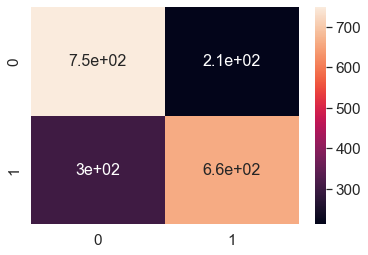

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_test, (model.predict(X_test) > 0.5) + 0)

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

LEAVE ONE OUT

In [21]:
def leaveOneOut(recordDatasets, datasetName):
    X_train, X_test, y_train, y_test = [], [], [], []
    for recordName in recordNames:
        if recordName == datasetName:
            X_test.extend(recordDatasets[recordName]['features'])
            y_test.extend(recordDatasets[recordName]['labels'])
        else:
            X_train.extend(recordDatasets[recordName]['features'])
            y_train.extend(recordDatasets[recordName]['labels'])
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train),np.array(y_test)
    model=returnModel()
    model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')
    num_epochs = 100
    num_batch_size = 32

    start = datetime.now()
    model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=0)


    duration = datetime.now() - start
    test_accuracy=model.evaluate(X_test,y_test,verbose=0)
    print(f"Accuract result of {datasetName}: {test_accuracy[1]}")
    return test_accuracy[1]

In [22]:
accuracy_scores = {}
for recordName in recordNames:
    accuracy_scores[recordName] = leaveOneOut(recordDatasets,recordName)

Accuract result of 4CH067I: 0.6450216174125671
Accuract result of 4CH068I: 0.7635281682014465
Accuract result of 4CH069I: 0.7389937043190002
Accuract result of 4CH071I: 0.75
Accuract result of 4CH072I: 0.7035176157951355
Accuract result of ENG1: 0.7855555415153503
Accuract result of ENG2: 0.7346625924110413
Accuract result of ENG3: 0.7364457845687866
Accuract result of MAAP2: 0.7469635605812073
Accuract result of MAAP3: 0.7746350169181824
Accuract result of MAAP7: 0.7886363863945007
Accuract result of POL1: 0.5177304744720459
Accuract result of POL2: 0.71875


In [23]:
labelNames = ['TR67', 'TR68', 'TR69', 'TR71', 'TR72', 'ENG1', 'ENG2', 'ENG3', 'MK2', 'MK3', 'MK7', 'PL1', 'PL2']
accuracy_scores.keys()

dict_keys(['4CH067I', '4CH068I', '4CH069I', '4CH071I', '4CH072I', 'ENG1', 'ENG2', 'ENG3', 'MAAP2', 'MAAP3', 'MAAP7', 'POL1', 'POL2'])

[Text(0, 0, '0.65'),
 Text(0, 0, '0.76'),
 Text(0, 0, '0.74'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.7'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.74'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.77'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.52'),
 Text(0, 0, '0.72')]

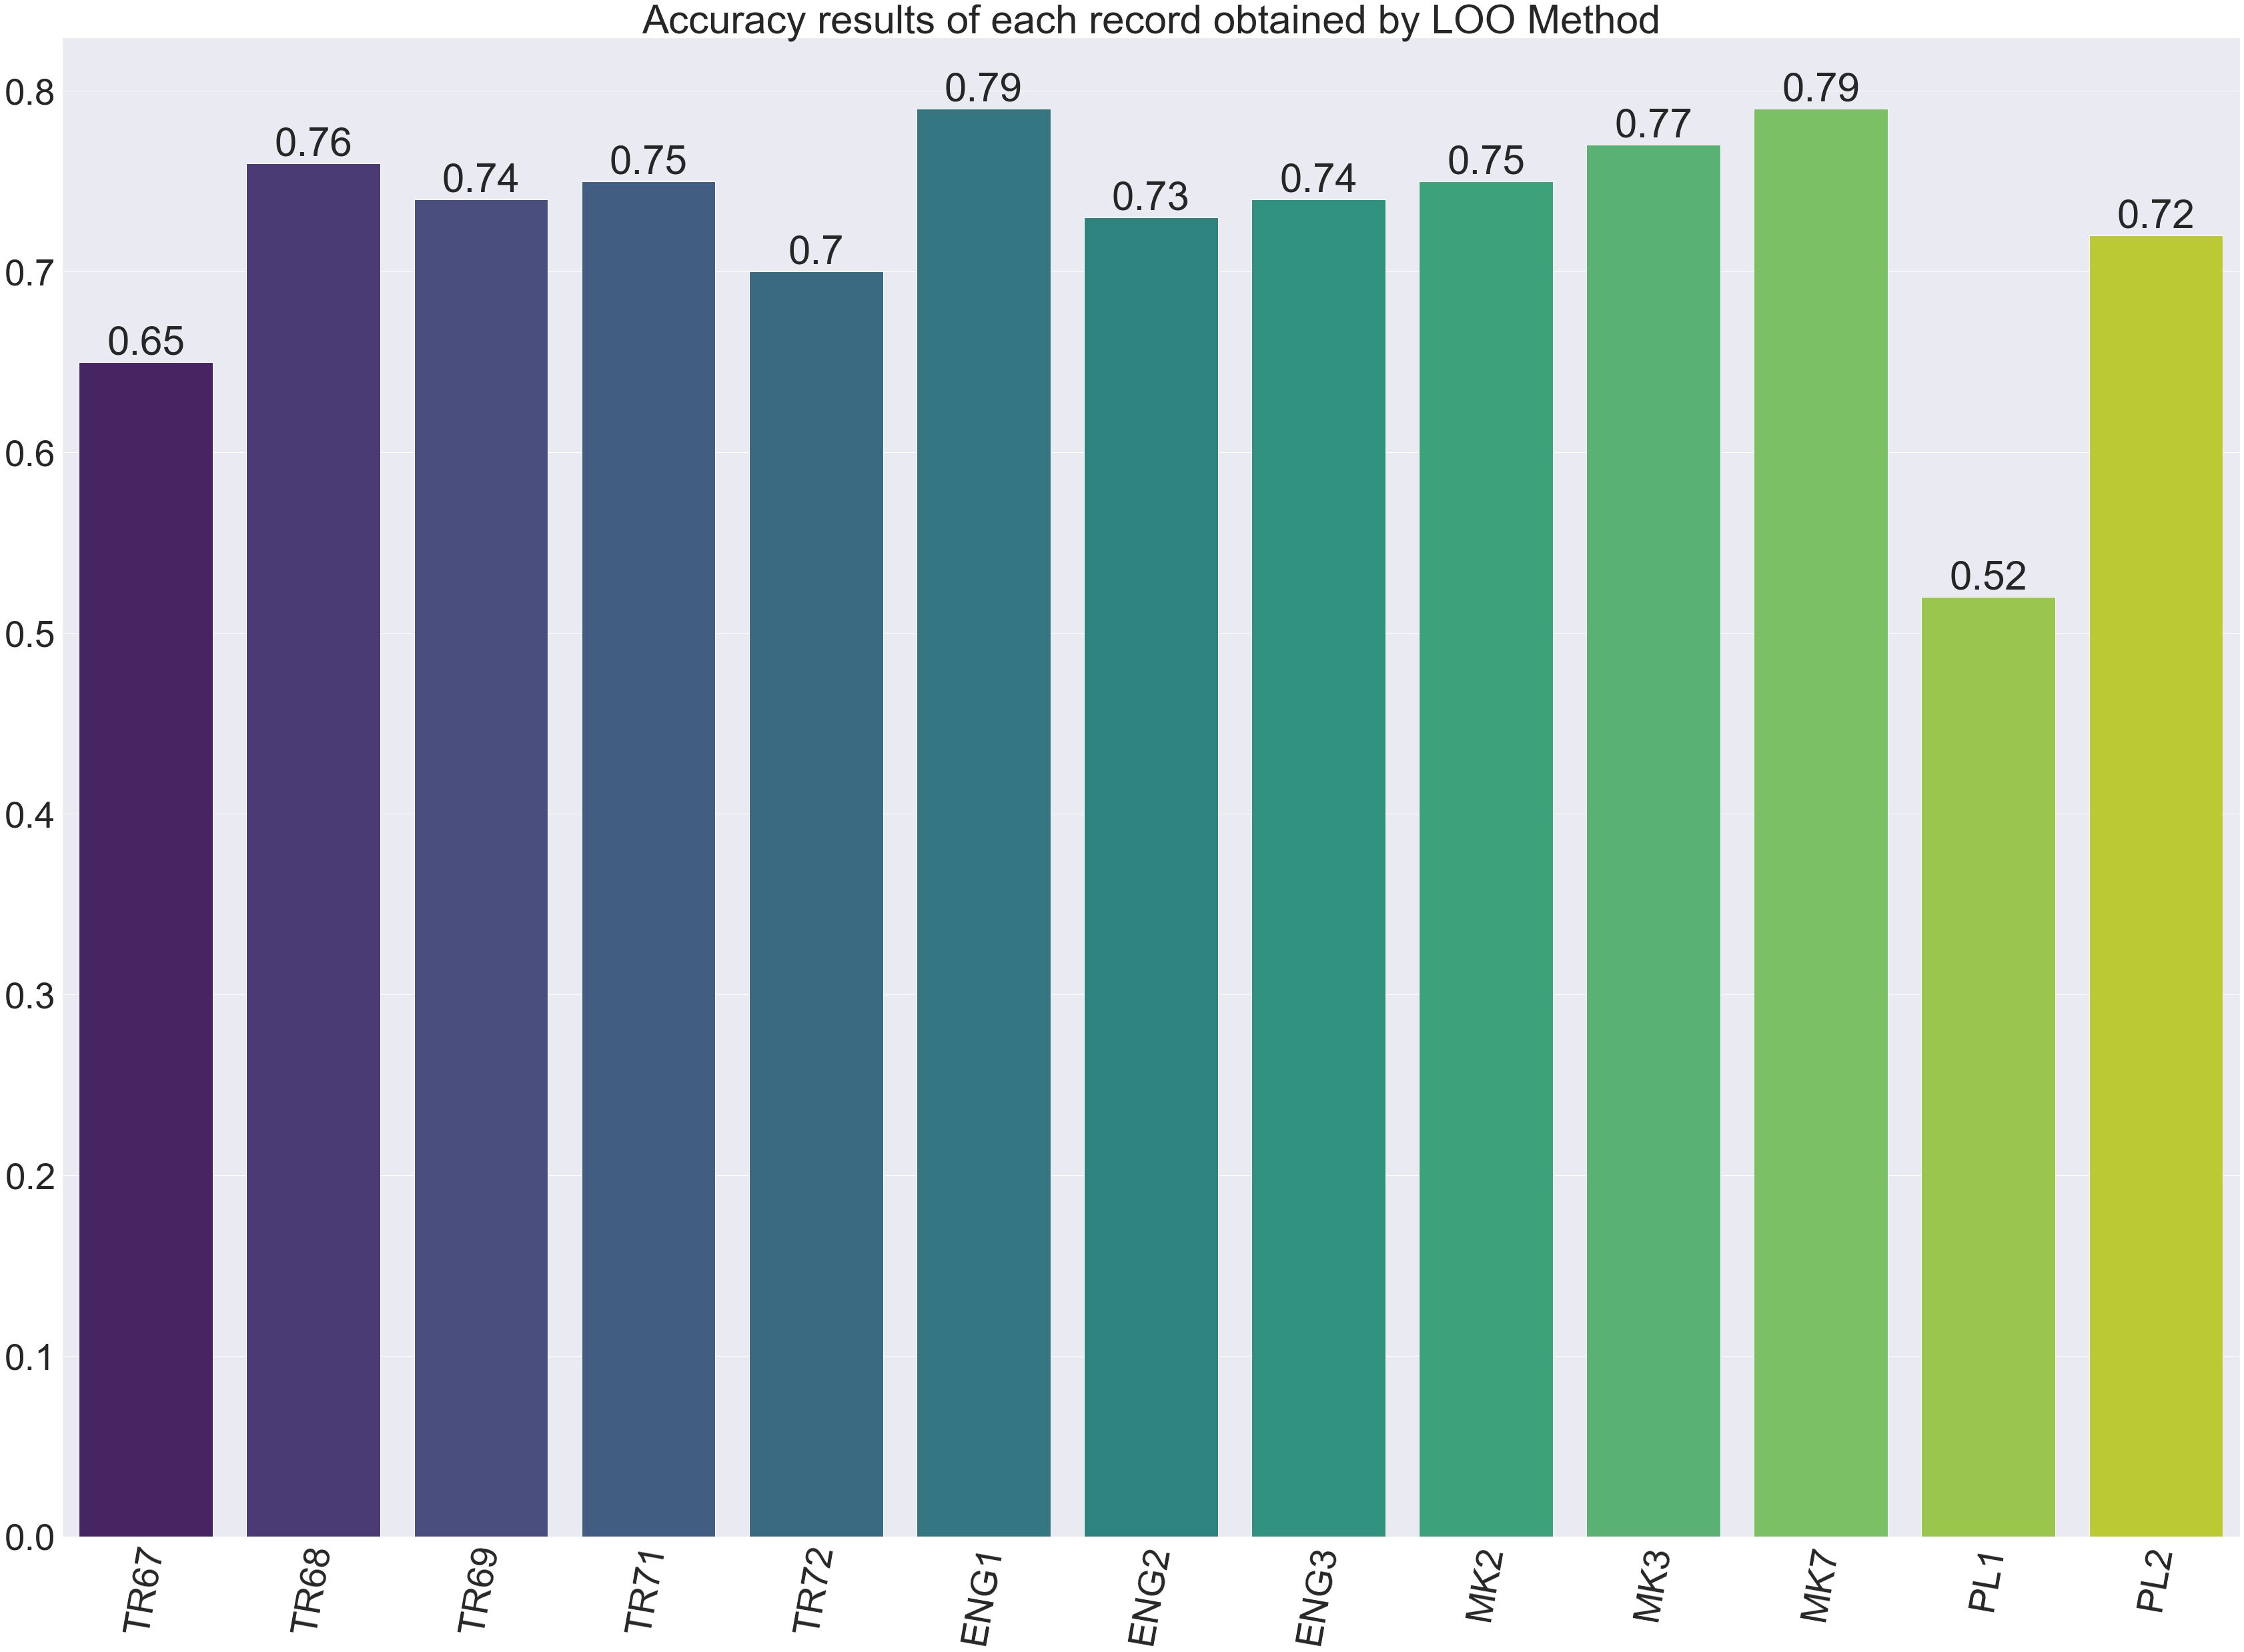

In [27]:
import seaborn as sn
sns.set(rc={'figure.figsize':(11.7 * 5,8.27 * 5)})
raw_data = {
    'x': list(labelNames),
    'y': np.round(list(accuracy_scores.values()), 2)
    }
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1.1,y_list[i-1]+0.01,y_list[i-1])
sns.set(font_scale = 5)
by_accuracy = sn.barplot(x='x', y='y', data=raw_data, palette='viridis', dodge='true')
for item in by_accuracy.get_xticklabels():
    item.set_rotation(80)
by_accuracy.set(title='Accuracy results of each record obtained by LOO Method')
by_accuracy.bar_label(by_accuracy.containers[0])


In [46]:
def calculateMeanAndVar(language):
    accs = []
    for recordName in recordNames:
        if language in recordName:
            accs.append(accuracy_scores[recordName])
    return np.mean(accs)*100, np.var(accs)*100
def returnMeanAndVarLists(languages):
    means, vars = [],[]
    for lan in languages:
        means.append(calculateMeanAndVar(lan)[0])
        vars.append(calculateMeanAndVar(lan)[1])
    return means, vars

[Text(0, 0, '0.65'),
 Text(0, 0, '0.76'),
 Text(0, 0, '0.74'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.7'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.74'),
 Text(0, 0, '0.75'),
 Text(0, 0, '0.77'),
 Text(0, 0, '0.79'),
 Text(0, 0, '0.52'),
 Text(0, 0, '0.72')]

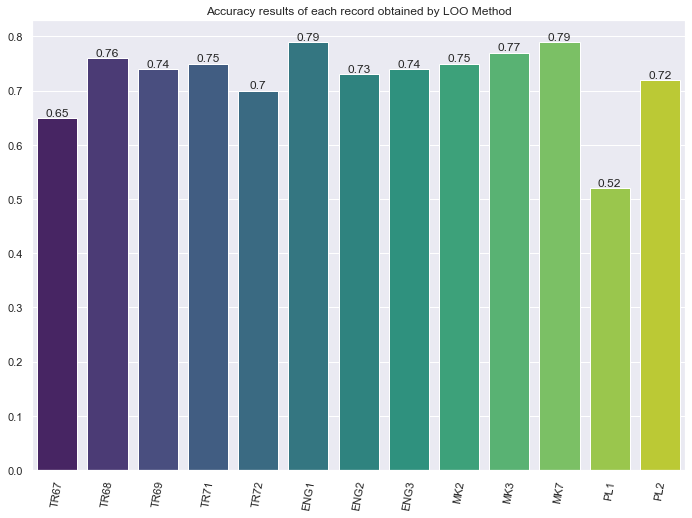

In [47]:
import seaborn as sn
sns.set(rc={'figure.figsize':(11.7,8.27)})
raw_data = {
    'x': list(labelNames),
    'y': np.round(list(accuracy_scores.values()), 2)
    }
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1.1,y_list[i-1]+0.01,y_list[i-1])
by_accuracy = sn.barplot(x='x', y='y', data=raw_data, palette='viridis', dodge='true')
for item in by_accuracy.get_xticklabels():
    item.set_rotation(80)
by_accuracy.set(title='Accuracy results of each record obtained by LOO Method')
by_accuracy.bar_label(by_accuracy.containers[0])


[Text(0, 0, '72.02'),
 Text(0, 0, '77.01'),
 Text(0, 0, '75.22'),
 Text(0, 0, '61.82')]

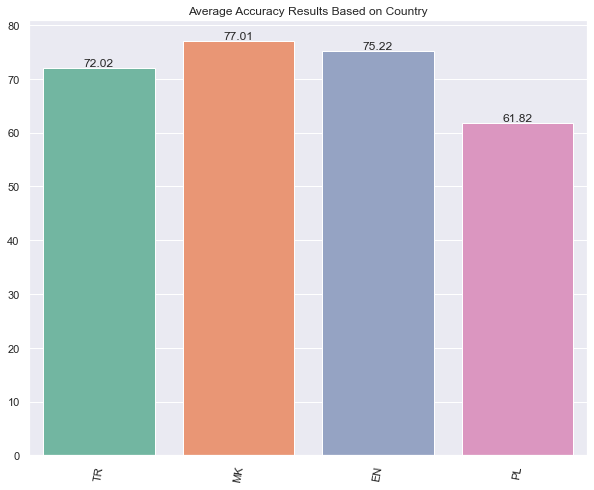

In [51]:
import seaborn as sn
sns.set(rc={'figure.figsize':(10,8)})
CTEs, error = returnMeanAndVarLists(['CH', 'MAAP', 'ENG', 'POL'])
raw_data = {
    'x': list(['TR', 'MK', 'EN', 'PL']),
    'y': np.round(list(CTEs), 2)
    }
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1.1,y_list[i-1]+0.01,y_list[i-1])
by_accuracy = sn.barplot(x='x', y='y', data=raw_data, palette='Set2', dodge='true')
for item in by_accuracy.get_xticklabels():
    item.set_rotation(80)
by_accuracy.set(title='Average Accuracy Results Based on Country')
by_accuracy.bar_label(by_accuracy.containers[0])


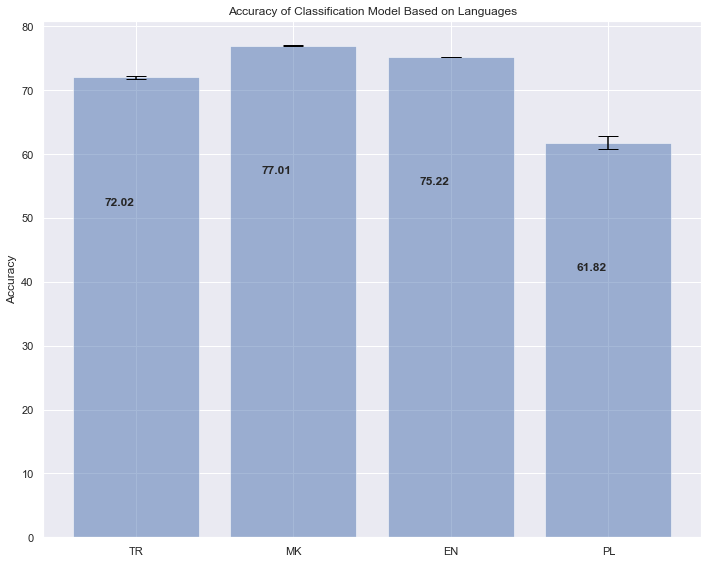

In [52]:
# Create lists for the plot
materials = ['TR', 'MK', 'EN', 'PL']
x_pos = np.arange(len(materials))
CTEs, error = returnMeanAndVarLists(['CH', 'MAAP', 'ENG', 'POL'])
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Accuracy of Classification Model Based on Languages')
ax.yaxis.grid(True)
for i, v in enumerate(np.round(CTEs, 2)):
    ax.text(i-0.2 , v - 20, str(v), fontweight = 'bold')
# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [30]:
finalModel=Sequential()
###first layer
finalModel.add(Dense(100,input_shape=(180,)))
finalModel.add(Activation('relu'))
finalModel.add(Dropout(0.5))
###second layer
finalModel.add(Dense(200))
finalModel.add(Activation('relu'))
finalModel.add(Dropout(0.5))
###third layer
finalModel.add(Dense(100))
finalModel.add(Activation('relu'))
finalModel.add(Dropout(0.5))

###final layer
finalModel.add(Dense(1))
finalModel.add(Activation('sigmoid'))
num_epochs = 100
num_batch_size = 32

finalModel.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

finalModel.fit(X, y, batch_size=num_batch_size, epochs=num_epochs, verbose=1)

Epoch 1/100
301/301 [==============================] - 1s 1ms/step - loss: 3.2059 - accuracy: 0.5502
Epoch 2/100
301/301 [==============================] - 0s 1ms/step - loss: 0.8761 - accuracy: 0.5565
Epoch 3/100
301/301 [==============================] - 0s 1ms/step - loss: 0.7284 - accuracy: 0.5764
Epoch 4/100
301/301 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.5948
Epoch 5/100
301/301 [==============================] - 0s 1ms/step - loss: 0.6642 - accuracy: 0.6162
Epoch 6/100
301/301 [==============================] - 0s 1ms/step - loss: 0.6408 - accuracy: 0.6420
Epoch 7/100
301/301 [==============================] - 0s 1ms/step - loss: 0.6271 - accuracy: 0.6657
Epoch 8/100
301/301 [==============================] - 0s 1ms/step - loss: 0.6050 - accuracy: 0.6901
Epoch 9/100
301/301 [==============================] - 0s 1ms/step - loss: 0.5886 - accuracy: 0.7091
Epoch 10/100
301/301 [==============================] - 0s 1ms/step - loss: 0.5740 - accura

In [31]:
exRecordDatasets = {}
exNumberOfSamples = []
exSampleNumbers = {}
allFeatures = []
allLabels = []
recordNames = os.listdir("./test/")
for recordName in recordNames:
    path_0 = os.path.relpath(f'./test/{recordName}/samples_0', cur_path)
    path_1 = os.path.relpath(f'./test/{recordName}/samples_1', cur_path)
    AudioFiles_0 = [f for f in os.listdir(path_0) if os.path.isfile(os.path.join(path_0, f))]
    AudioFiles_1 = [f for f in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, f))]
    exSampleNumbers[recordName] = {
        "Child" : len(AudioFiles_1),
        "NonChild" : len(AudioFiles_0)
    }
    exFeatures = []
    exLabels = []
    n = min(len(AudioFiles_0), len(AudioFiles_1))
    selectedSamples_0 = random.sample(AudioFiles_0, n)
    selectedSamples_1 = random.sample(AudioFiles_1, n)
    for i in range(n):
        exFeatures.append(extract_feature(path_0 + "/" + selectedSamples_0[i], mfcc=True, chroma=True, mel=True))
        exLabels.append(0)
        exFeatures.append(extract_feature(path_1 + "/" + selectedSamples_1[i], mfcc=True, chroma=True, mel=True))
        exLabels.append(1)
    allFeatures.extend(exFeatures)
    allLabels.extend(exLabels)
    print(f"Dataset: {recordName} Number of Samples: {len(exLabels)}")
    exRecordDatasets[f"{recordName}"] = {
        "exFeatures" : exFeatures,
        "exLabels" : exLabels
    }
    exNumberOfSamples.append(len(exLabels))

Dataset: MAAP5 Number of Samples: 1122
Dataset: 4CH065I Number of Samples: 514
Dataset: 4CH066I Number of Samples: 2292
Dataset: MAAP6 Number of Samples: 768


In [32]:
len(exLabels)

768

In [33]:
MAAPFeatures = []
MAAPLabels = []

MAAPFeatures.extend(exRecordDatasets['MAAP5']['exFeatures'])
MAAPFeatures.extend(exRecordDatasets['MAAP6']['exFeatures'])
MAAPLabels.extend(exRecordDatasets['MAAP5']['exLabels'])
MAAPLabels.extend(exRecordDatasets['MAAP6']['exLabels'])

MAAPpredictions = (model.predict(np.array(MAAPFeatures)) > 0.5) + 0

# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(MAAPLabels, MAAPpredictions)}")
# Importing all necessary libraries
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(MAAPLabels, MAAPpredictions)}")
from sklearn.metrics import recall_score

# Calculating the recall score of classifier
print(f"Recall Score of the classifier is: {recall_score(MAAPLabels, MAAPpredictions)}")

# Importing all necessary libraries
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(MAAPLabels, MAAPpredictions)}")

Accuracy of the classifier is: 0.7592592592592593
Precision Score of the classifier is: 0.7634408602150538
Recall Score of the classifier is: 0.7513227513227513
F1 Score of the classifier is: 0.7573333333333332


In [34]:
TRFeatures = []
TRLabels = []

TRFeatures.extend(exRecordDatasets['4CH065I']['exFeatures'])
TRFeatures.extend(exRecordDatasets['4CH066I']['exFeatures'])
TRLabels.extend(exRecordDatasets['4CH065I']['exLabels'])
TRLabels.extend(exRecordDatasets['4CH066I']['exLabels'])

TRpredictions = (model.predict(np.array(TRFeatures)) > 0.5) + 0

# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(TRLabels, TRpredictions)}")
# Importing all necessary libraries
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(TRLabels, TRpredictions)}")
from sklearn.metrics import recall_score

# Calculating the recall score of classifier
print(f"Recall Score of the classifier is: {recall_score(TRLabels, TRpredictions)}")

# Importing all necessary libraries
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(TRLabels, TRpredictions)}")

Accuracy of the classifier is: 0.883464005702067
Precision Score of the classifier is: 0.8859397417503587
Recall Score of the classifier is: 0.880256593014968
F1 Score of the classifier is: 0.8830890239542367


In [35]:
maapResults = [accuracy_score(MAAPLabels, MAAPpredictions), precision_score(MAAPLabels, MAAPpredictions), recall_score(MAAPLabels, MAAPpredictions), f1_score(MAAPLabels, MAAPpredictions)]
TRResults = [accuracy_score(TRLabels, TRpredictions), precision_score(TRLabels, TRpredictions), recall_score(TRLabels, TRpredictions), f1_score(TRLabels, TRpredictions)]


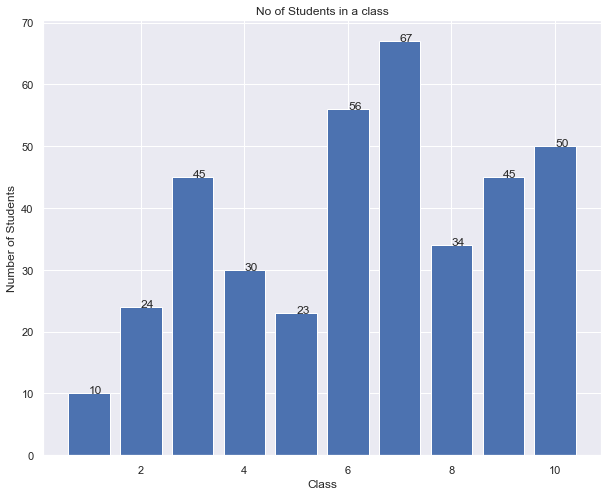

In [36]:
import matplotlib.pyplot as plt

def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1],y_list[i-1])

no_of_students=[10,24,45,30,23,56,67,34,45,50]
class_number=[1,2,3,4,5,6,7,8,9,10]
plt.bar(class_number,no_of_students)
add_value_label(class_number,no_of_students)
plt.title("No of Students in a class")
plt.xlabel("Class")
plt.ylabel("Number of Students")
plt.show()

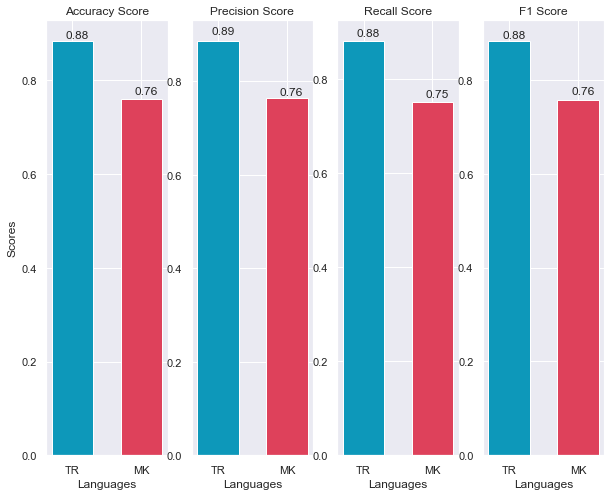

In [53]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1.1,y_list[i-1]+0.01,y_list[i-1])
metricNames = ['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score']
for i in range(4):
    plt.subplot(1, 4, i+1,)
    plt.bar(['TR', 'MK'], [TRResults[i], maapResults[i]], color = ["#0d98ba", "#de415b"], width = 0.6)
    plt.title(metricNames[i])
    add_value_label([1,2], np.round([TRResults[i], maapResults[i]], 2))
    plt.xlabel('Languages') 
    if i == 0:
        plt.ylabel('Scores')

In [39]:
predictions = (model.predict(np.array(allFeatures)) > 0.5) + 0


In [40]:
# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(allLabels, predictions)}")

Accuracy of the classifier is: 0.8334752981260647


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(allLabels, predictions)}")

Precision Score of the classifier is: 0.8049689440993789


In [ ]:
from sklearn.metrics import recall_score

# Calculating the recall score of classifier
print(f"Recall Score of the classifier is: {recall_score(allLabels, predictions)}")

Recall Score of the classifier is: 0.7916666666666666


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(exLabels, predictions)}")

F1 Score of the classifier is: 0.8063660477453581


[[1877  471]
 [ 404 1944]]


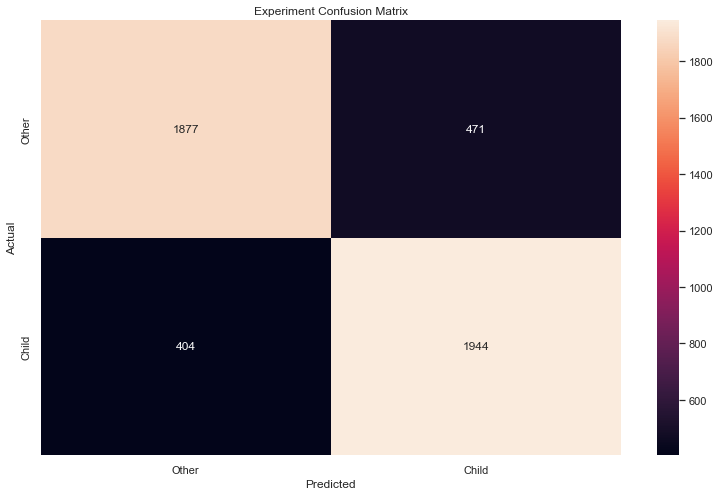

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def conf_matrix(y_test,y_pred,observed_emotions):
    cm = confusion_matrix(y_test, y_pred)
    ## Print the Confusion Matrix
    print(cm)
    ## Call the heatmap() function from the Seaborn Library.
    ## annot=True annotates cells.
    ## fmt='g' disables scientific notation.
    sns.set(rc = {'figure.figsize':(13,8)})
    ## The heatmap() function returns a Matplotlib Axes Object.
    ax = sns.heatmap(cm, annot=True, fmt='g');
    ## Modify the Axes Object directly to set various attributes such as the
    ## Title, X/Y Labels.
    ax.set_title('Experiment Confusion Matrix');
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');
    ## For the Tick Labels, the labels should be in Alphabetical order
    ax.xaxis.set_ticklabels(observed_emotions)
    ax.yaxis.set_ticklabels(observed_emotions)
    ## Finally call the matplotlib show() function to display the visualization
    ## of the Confusion Matrix.


    plt.show()
conf_matrix(allLabels, predictions,['Other', 'Child'])

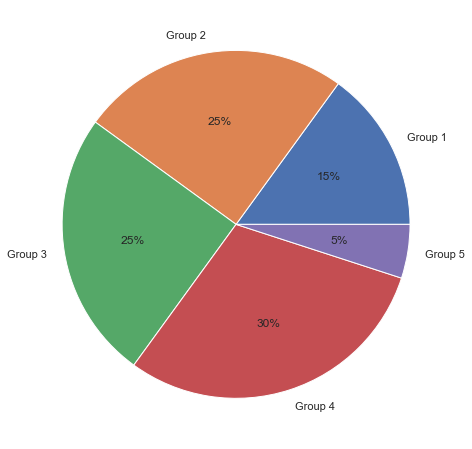

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = [15, 25, 25, 30, 5]
labels = ['Group 1', 'Group 2']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, autopct='%.0f%%')
plt.show()

In [ ]:
list(SampleNumbers.keys())

['4CH067I',
 '4CH068I',
 '4CH069I',
 '4CH071I',
 '4CH072I',
 'ENG1',
 'ENG2',
 'ENG3',
 'MAAP2',
 'MAAP3',
 'MAAP7',
 'POL1',
 'POL2']

In [ ]:
LANGS = ['TR','TR','TR','TR','TR','EN','EN','EN','HU','HU','HU','PL','PL' ]

In [ ]:
fig = plt.figure(figsize=(18,10), dpi=1600)
for i in range(len(SampleNumbers.keys())-1):
    name = list(SampleNumbers.keys())[i]
    d = [SampleNumbers[name]['NonChild'], SampleNumbers[name]['Child']]
    plt.subplot(3, 4, i+1)
    plt.pie(d, labels = ['Others', 'Child'], colors=['#581845', '#FF5733'],  autopct='%1.1f%%')
    plt.legend()
    plt.title(LANGS[i])

In [55]:
fig = plt.figure(figsize=(12,3), dpi=1600)
for i in range(len(exSampleNumbers.keys())):
    name = list(exSampleNumbers.keys())[i]
    print(name)
    names =  ['MK1', 'TR1', 'TR2', 'MK2']
    d = [exSampleNumbers[name]['NonChild'], exSampleNumbers[name]['Child']]
    plt.subplot(1, 4, i+1)
    plt.pie(d, labels = ['Others', 'Child'], colors=['#F4A896', '#358597'], autopct='%1.1f%%')
    plt.legend()
    plt.title(names[i])

MAAP5
4CH065I
4CH066I
MAAP6
